In [1]:
!pip install -q pennylane numpy pandas scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.1 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load the datasets
features_path = "features_raw.csv"  # Replace with your path
emotions_path = "emotions.csv"  # Replace with your path

features_raw = pd.read_csv(features_path)
emotions = pd.read_csv(emotions_path, low_memory=False)
print("Datasets loaded successfully!")


Datasets loaded successfully!


In [4]:
features_raw.head()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2,Unnamed: 32
0,0.057813,-1.335266,4.640480,0.219573,7.473817,2.314842,1.918097,-9.257533,9.089943,-7.104519,...,-2.241480,1.415335,2.406646,12.864059,4.021099,-2.828598,-2.588735,2.637905,-5.226618,NaN
1,1.367408,10.259654,3.345409,7.897852,-2.446051,-1.655035,-6.301423,-7.290317,-3.546453,-5.705187,...,-2.568397,-5.651418,-0.096730,-4.930759,-1.722504,-6.111309,0.094893,-3.521353,1.887093,NaN
2,-1.783132,4.133553,-0.951680,-1.624803,-1.827309,-2.280364,-2.279225,9.151344,-0.239575,-0.057604,...,-2.132823,-0.521117,8.605298,-4.499946,-3.232839,-4.249645,-3.687167,-7.383004,-4.489537,NaN
3,-3.690217,-0.814000,2.295469,0.901445,8.323679,1.127906,6.356886,11.642082,9.354154,-1.662478,...,-0.506117,-1.154866,-3.940251,7.390881,2.129897,-0.794675,-1.959021,2.774530,-6.323060,NaN
4,2.137114,6.420466,6.122230,10.015321,3.106394,3.183129,3.658535,4.571793,4.917712,-2.325940,...,1.813907,-6.444635,-27.680880,0.641364,1.996658,-0.445779,2.614021,6.161845,3.308816,NaN


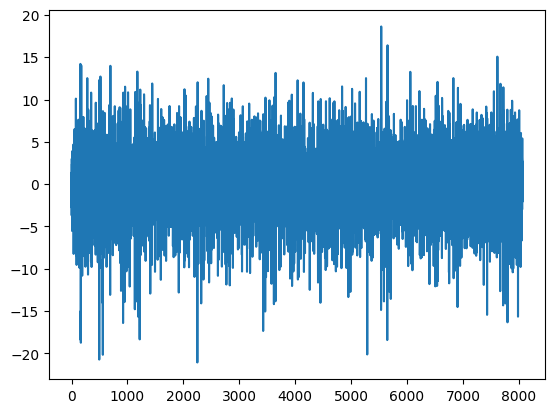

In [5]:
plt.plot(features_raw['Fp1'])


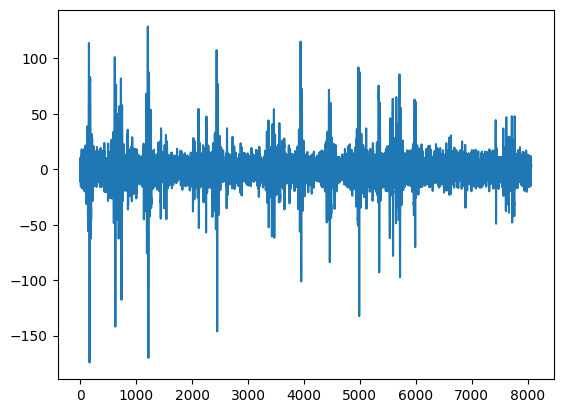

In [6]:
plt.plot(features_raw['AF3'])

In [7]:
# Data Preparation

# Extract features and labels from emotions.csv
X = emotions.drop(columns=["label"])
y = emotions["label"]

# Handle missing values and limit features for memory efficiency
X.fillna(X.mean(), inplace=True)
X = X.iloc[:, :1000]  # Downsample features

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize and apply PCA
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
pca = PCA(n_components=10)  # Reduce dimensionality while retaining variance
X_pca = pca.fit_transform(X_normalized)


In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


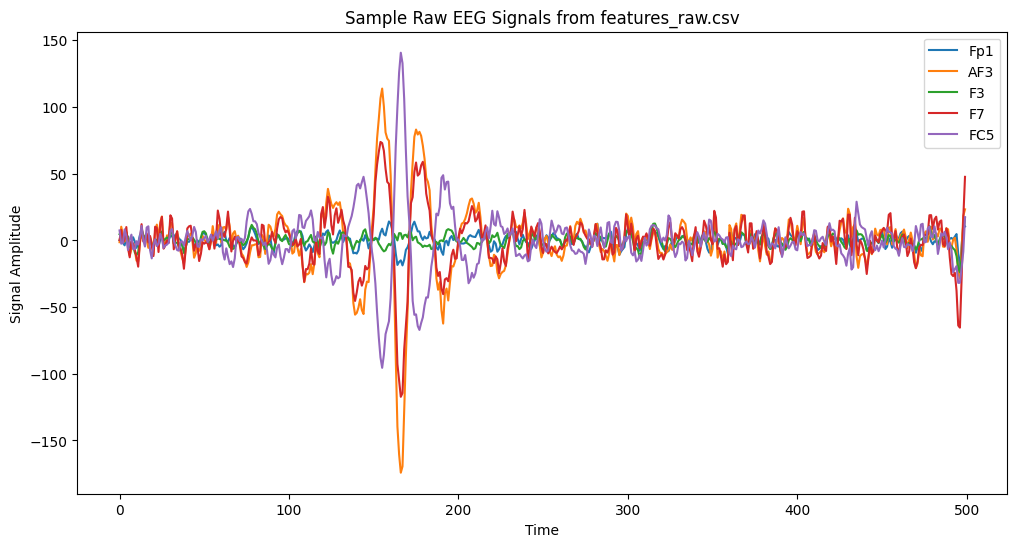

In [9]:
# Visualize raw features (features_raw.csv)
plt.figure(figsize=(12, 6))
plt.plot(features_raw.iloc[:500, :5])  # Plot first 500 samples for first 5 channels
plt.title("Sample Raw EEG Signals from features_raw.csv")
plt.xlabel("Time")
plt.ylabel("Signal Amplitude")
plt.legend(features_raw.columns[:5])
plt.show()


In [11]:
# Define quantum device
n_qubits = X_train.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

# Define quantum circuit
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


In [12]:
# Initialize QNode with torch interface
qnode = qml.QNode(quantum_circuit, dev, interface="torch")

# Define quantum-classical hybrid model
weight_shapes = {"weights": (3, n_qubits, 3)}  # Three layers of weights
classifier = qml.qnn.TorchLayer(qnode, weight_shapes)

In [13]:
class HybridClassifier(nn.Module):
    def __init__(self):
        super(HybridClassifier, self).__init__()
        self.quantum_layer = classifier
        self.fc1 = nn.Linear(n_qubits, 32)
        self.fc2 = nn.Linear(32, len(np.unique(y_encoded)))

    def forward(self, x):
        x = self.quantum_layer(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
# Model setup
model = HybridClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [15]:
# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)


In [21]:
import torch

# Training loop
epochs = 50
train_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Save the model
torch.save(model.state_dict(), "Qc_kaggle_model.pth")
print("Model has been saved to 'Qc_kaggle_model.pth'")


Epoch 10/50, Loss: 0.5248637795448303
Epoch 20/50, Loss: 0.515439510345459
Epoch 30/50, Loss: 0.5080652236938477
Epoch 40/50, Loss: 0.5016328692436218
Epoch 50/50, Loss: 0.49605756998062134
Model has been saved to 'Qc_kaggle_model.pth'


In [22]:
# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test_torch).argmax(dim=1).numpy()
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Accuracy: 0.7189695550351288
[[ 97   7  38]
 [ 17 121   5]
 [ 50   3  89]]
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       142
           1       0.92      0.85      0.88       143
           2       0.67      0.63      0.65       142

    accuracy                           0.72       427
   macro avg       0.73      0.72      0.72       427
weighted avg       0.73      0.72      0.72       427



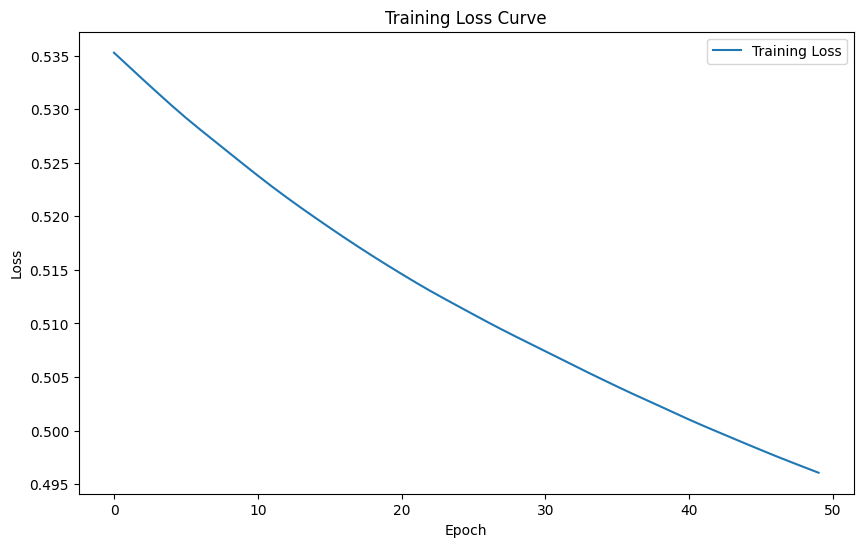

In [23]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()


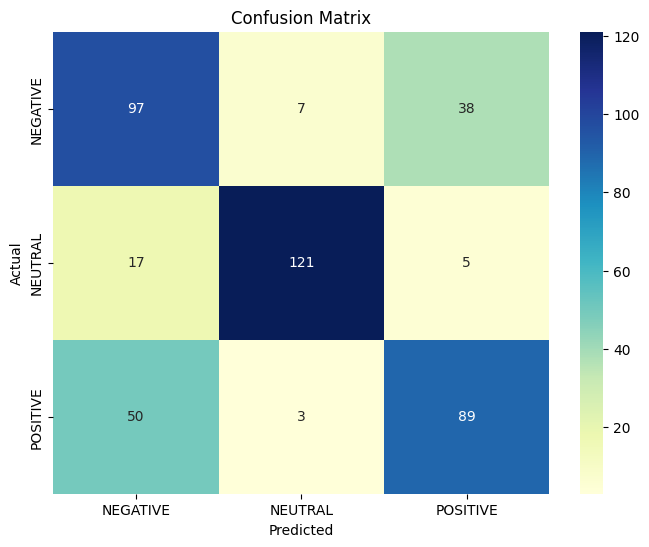

In [24]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

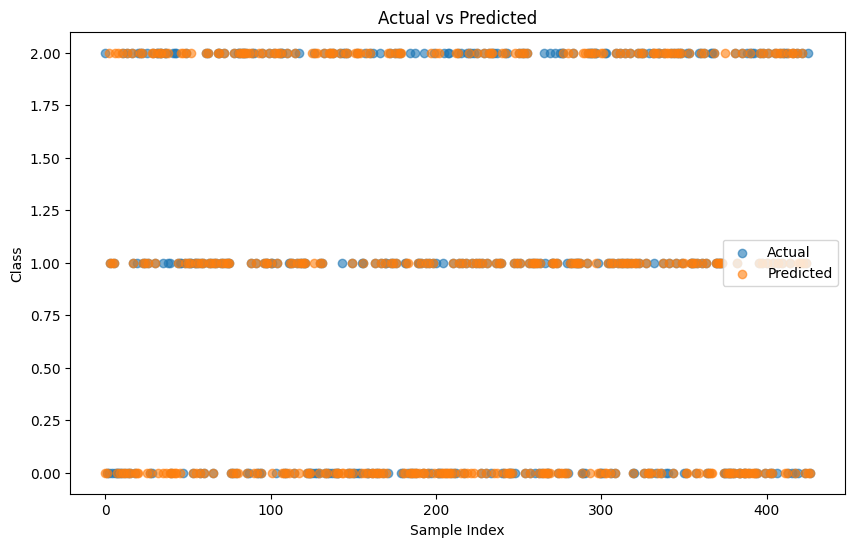

In [25]:
# Actual vs Predicted Visualization
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.6)
plt.legend()
plt.title("Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Class")
plt.show()